In [1]:
import os
from pathlib import Path
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import combinedPlot
from UCB_training.UCB_utils import fancyCombinedPlot

## Set up Working Directory

In [2]:
# Dynamically find the repo root from the current working directory
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

# Construct the target path
target_path = os.path.join(library_path, 'UCB_training', 'models', 'calpella_all')

# Verify if the directory exists before changing
if os.path.exists(target_path):
    os.chdir(target_path)
    print("Current Working Directory:", os.getcwd())
    print("Train Basin File Exists:", os.path.exists("calpella")) #each basin has its own train basin file, so change for different basins e.g "guerneville", etc.
else:
    print(f"Error: The target path '{target_path}' does not exist.")

Current Working Directory: /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all
Train Basin File Exists: True


In [3]:
path_to_csv = Path(library_path +'/russian_river_data')
path_to_yaml = Path("calpella_gage.yaml") #update the yaml file for different basins

## Standard daily LSTM (no ensembles, no physics), train on training subset, evaluated on validation period

In [5]:
params = {
    "epochs":5,
    "hidden_size": 128,
    "output_dropout": 0.4,
    "seq_length": 90,
}
lstmNoPhysicsHourly = UCB_trainer(path_to_csv, yaml_path= path_to_yaml, hyperparams= params, hourly=True)

In [6]:
lstmNoPhysicsHourly.train()

2025-02-04 16:47:12,221: Logging to /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_164712/output.log initialized.
2025-02-04 16:47:12,222: ### Folder structure created at /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_164712
2025-02-04 16:47:12,223: ### Run configurations for testing_run
2025-02-04 16:47:12,223: experiment_name: testing_run
2025-02-04 16:47:12,224: train_basin_file: calpella
2025-02-04 16:47:12,224: validation_basin_file: calpella
2025-02-04 16:47:12,225: test_basin_file: calpella
2025-02-04 16:47:12,225: train_start_date: 1994-10-01 00:00:00
2025-02-04 16:47:12,226: train_end_date: 2002-09-30 00:00:00
2025-02-04 16:47:12,226: validation_start_date: 2002-10-01 00:00:00
2025-02-04 16:47:12,227: validation_end_date: 2005-09-30 00:00:00
2025-02-04 16:47:12,228: test_start_date: 2005-10-01 00:00:00
2025-02-04 16:47:12,232: test_end_date: 2009-09-30 00:00:00
2025-02-04 16:47:12,233: devi

/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/evaluation/tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(weight_file

# Validation: 100%|██████████| 1/1 [00:45<00:00, 45.46s/it]
2025-02-04 17:03:54,160: Stored metrics at /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_164712/validation/model_epoch005/validation_metrics.csv
2025-02-04 17:03:54,161: Stored results at /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_164712/validation/model_epoch005/validation_results.p


PosixPath('/Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_164712')

got predictions


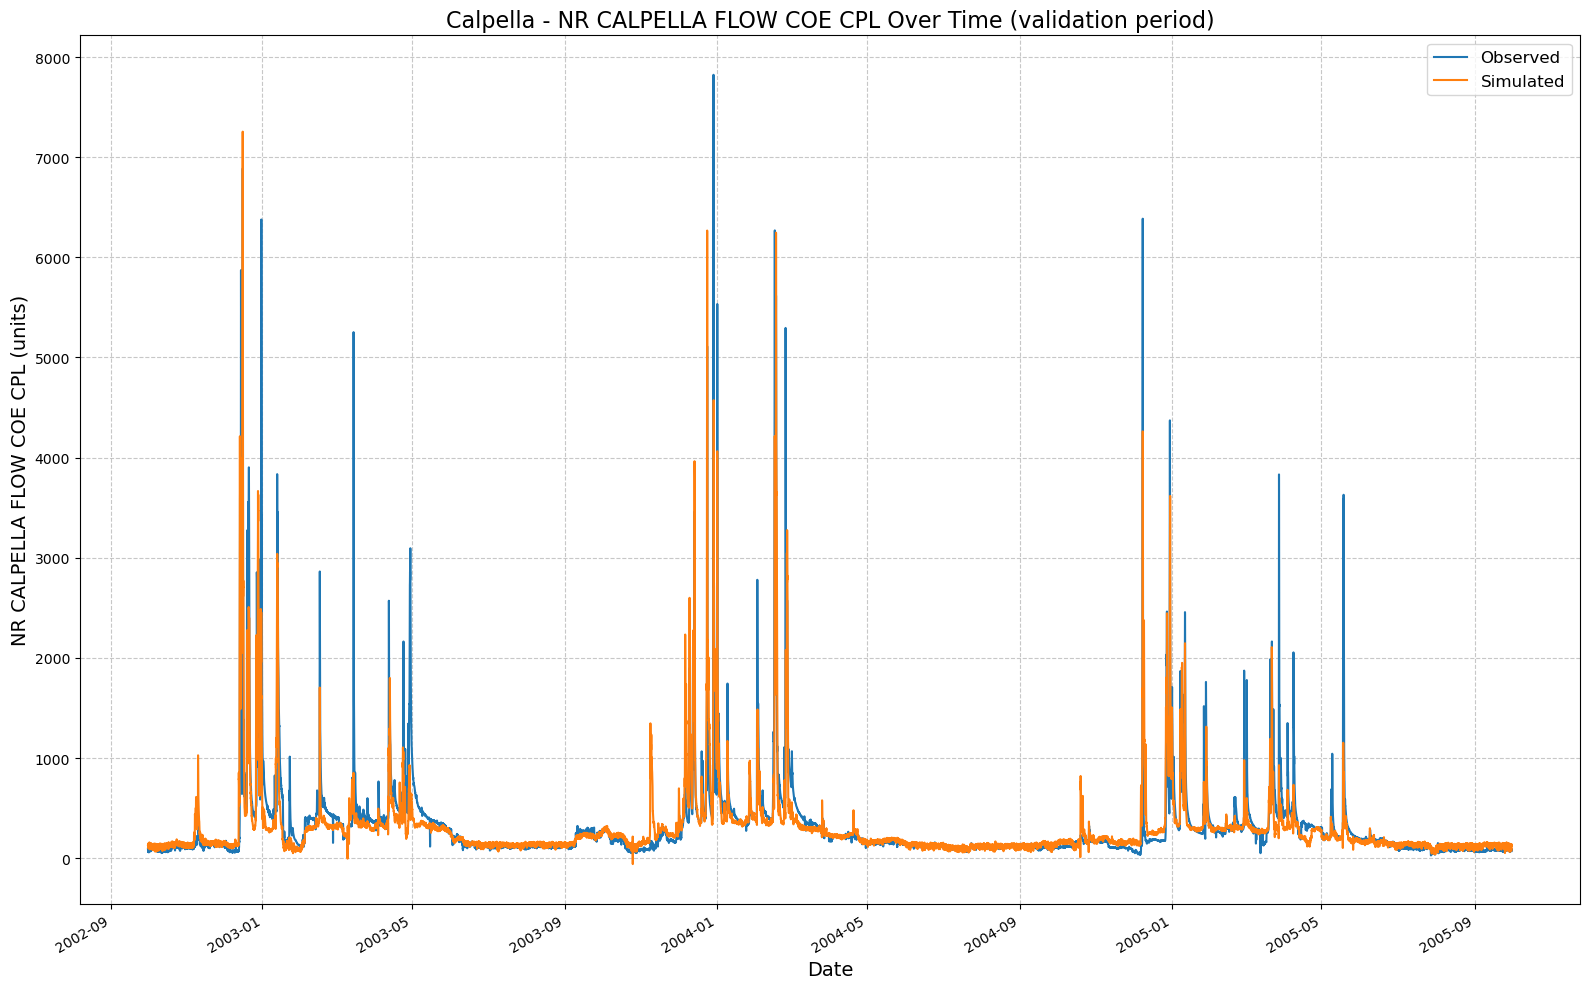

[INFO] CSV output saved at: /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_164712/results_output_validation.csv


/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


{'NSE': 0.6736319363117218,
 'MSE': 71287.6484375,
 'RMSE': 266.9974689720859,
 'KGE': 0.7585123403242461,
 'Alpha-NSE': 0.8451859288974861,
 'Beta-KGE': 0.9490383267402649,
 'Beta-NSE': -0.03453065983465151,
 'Pearson-r': 0.8218096494674683,
 'FHV': -12.997959554195404,
 'FMS': -31.99554001525814,
 'FLV': -1401.4075487236494,
 'Peak-Timing': nan,
 'Peak-MAPE': 48.229241371154785}

In [7]:
#outputs simple graph, also logs where the csv where the results are stored (use this csv for when you plot combined graph), also prints the metrics
lstmNoPhysicsHourly.results() 

## Physics-Informed LSTM (PLSTM) trained on training set, validated on validation set


In [18]:
path_to_physics_data = Path(library_path +"/russian_river_data/Calpella_hourly.csv")
params = {
    "epochs":5,
    "hidden_size": 128,
    "output_dropout": 0.4,
    "seq_length": 90,
}
features_with_physics = [
    #from hourly
    "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "EF RUSSIAN 20 PRECIP-INC SCREENED",
    "POTTER VALLEY CA FLOW USGS_ADJUSTED",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    #from new capella.csv
    'Capella Gage FLOW',
    'EF Russian 20 ET-POTENTIAL',
    'EF Russian 20 FLOW',
    'EF Russian 20 FLOW-BASE',
    'EF Russian 20 INFILTRATION',
    'EF Russian 20 PERC-SOIL',
    'EF Russian 20 SATURATION FRACTION',
#    'Lake Mendocino Storage',
    ]
lstmPhysicsHourly = UCB_trainer(path_to_csv, yaml_path= path_to_yaml, hyperparams= params, input_features= features_with_physics, physics_informed=True, physics_data_file=path_to_physics_data, hourly=True)

In [19]:
current_path = os.getcwd()
print(current_path)
print()

/Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all



In [20]:
lstmPhysicsHourly.train()

2025-02-04 17:39:55,779: Logging to /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_173955/output.log initialized.
2025-02-04 17:39:55,781: ### Folder structure created at /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_173955
2025-02-04 17:39:55,781: ### Run configurations for testing_run
2025-02-04 17:39:55,782: experiment_name: testing_run
2025-02-04 17:39:55,783: train_basin_file: calpella
2025-02-04 17:39:55,783: validation_basin_file: calpella
2025-02-04 17:39:55,784: test_basin_file: calpella
2025-02-04 17:39:55,784: train_start_date: 1994-10-01 00:00:00
2025-02-04 17:39:55,785: train_end_date: 2002-09-30 00:00:00
2025-02-04 17:39:55,786: validation_start_date: 2002-10-01 00:00:00
2025-02-04 17:39:55,786: validation_end_date: 2005-09-30 00:00:00
2025-02-04 17:39:55,786: test_start_date: 2005-10-01 00:00:00
2025-02-04 17:39:55,787: test_end_date: 2009-09-30 00:00:00
2025-02-04 17:39:55,787: devi

/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/evaluation/tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(weight_file

# Validation: 100%|██████████| 1/1 [00:48<00:00, 48.93s/it]
2025-02-04 19:07:00,045: Stored metrics at /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_173955/validation/model_epoch005/validation_metrics.csv
2025-02-04 19:07:00,050: Stored results at /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_173955/validation/model_epoch005/validation_results.p


PosixPath('/Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_173955')

got predictions


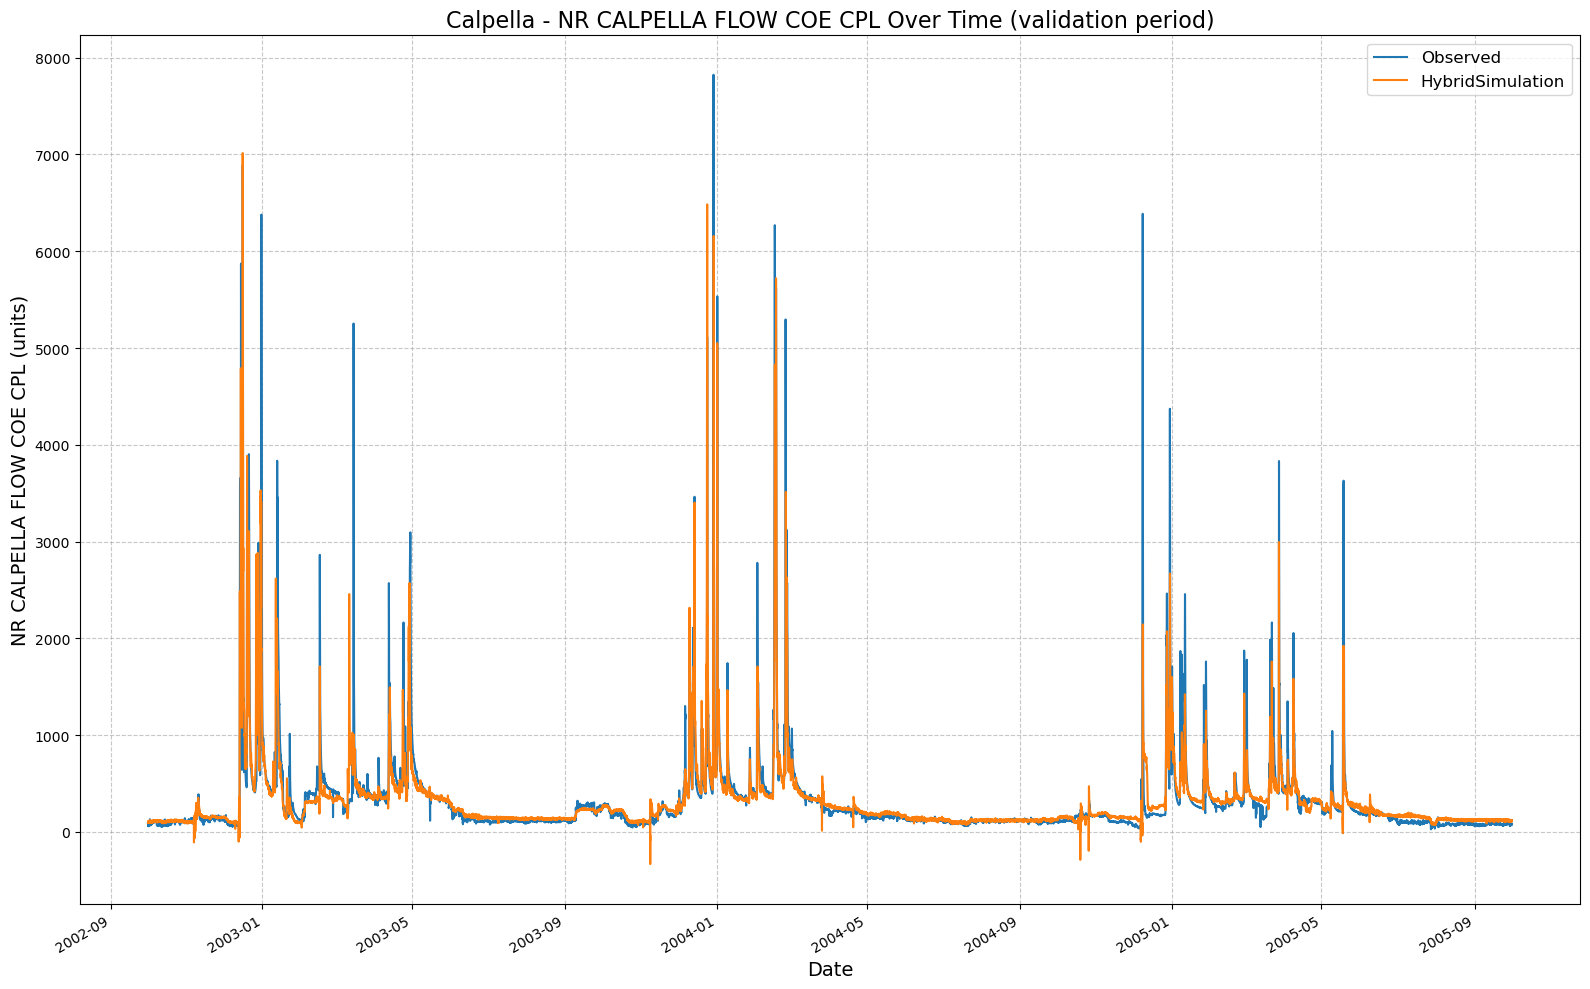

[INFO] CSV output saved at: /Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_173955/results_output_validation.csv


/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


{'NSE': 0.7495385110378265,
 'MSE': 54707.5859375,
 'RMSE': 233.89652827158423,
 'KGE': 0.7996382102919993,
 'Alpha-NSE': 0.8511456153763176,
 'Beta-KGE': 0.9995362758636475,
 'Beta-NSE': -0.0003142107081860117,
 'Pearson-r': 0.8658843636512756,
 'FHV': -15.38132131099701,
 'FMS': -19.92525331326179,
 'FLV': -1394.1260085364981,
 'Peak-Timing': nan,
 'Peak-MAPE': 45.09248435497284}

In [21]:
lstmPhysicsHourly.results()

/Users/mia/research/UCB-USACE-LSTMs/UCB_training/UCB_utils.py:44: DtypeWarning: Columns (0,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  hms_df = pd.read_csv(HMS_results) #columns: Date, HMS_predicted
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

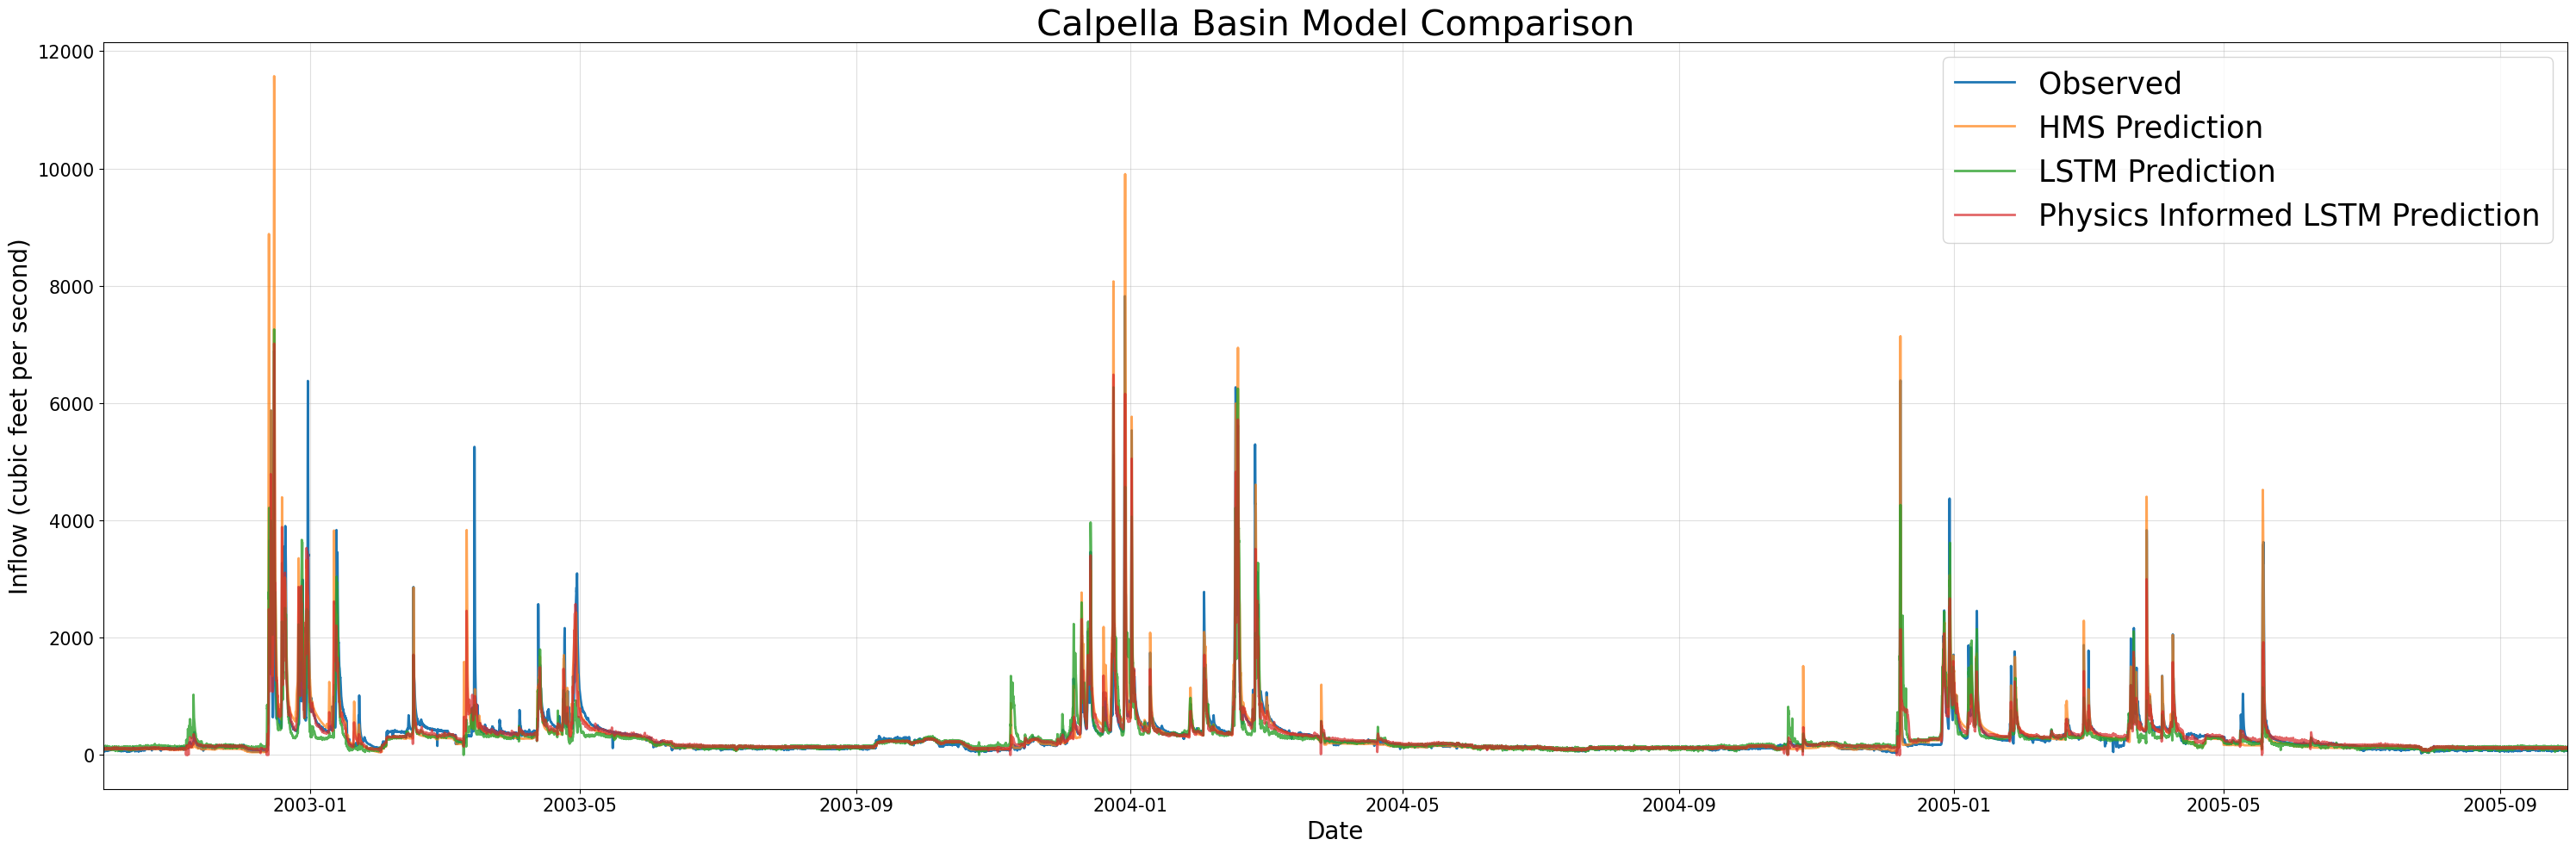

In [22]:
lstm_results_path = '/Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_164712/results_output_validation.csv'
lstmPhysics_results_path = '/Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_173955/results_output_validation.csv'
myplot, metrics_df = combinedPlot(lstm_results=lstm_results_path, lstmPhysics_results= lstmPhysics_results_path, HMS_results=path_to_physics_data, title='Calpella Basin Model Comparison', fName = "calpella_metrics.csv")

In [23]:
metrics_df

HMS          LSTM  Physics_Informed_LSTM
NSE              0.629094      0.673634               0.749773
MSE          81016.005413  71287.116501           54656.301556
RMSE           284.633107    266.996473             233.786872
KGE              0.735685      0.758515               0.799563
Alpha-NSE        1.225445      0.845187               0.850916
Beta-KGE         1.045636      0.949046               0.999883
Beta-NSE         0.030922     -0.034526              -0.000079
Pearson-r        0.869792      0.821811               0.866026
FHV             17.058090    -12.997960             -15.381321
FMS             -9.898612    -31.995564             -19.925270
FLV             35.983666  -1401.407457           -1394.125789
Peak-Timing           NaN           NaN                    NaN
Peak-MAPE       35.530528     48.229239              45.092485

## If you prefer the interactive plotly graph , you can use 'fancyCombinedPlot' (must have plotly library downloaded)

In [4]:
lstm_results_path = '/Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_164712/results_output_validation.csv'
lstmPhysics_results_path = '/Users/mia/research/UCB-USACE-LSTMs/UCB_training/models/calpella_all/runs/testing_run_0402_173955/results_output_validation.csv'
path_to_physics_data = Path(library_path +"/russian_river_data/Calpella_hourly.csv")

In [5]:
fancyCombinedPlot(lstm_results=lstm_results_path, lstmPhysics_results= lstmPhysics_results_path, HMS_results=path_to_physics_data, title='Calpella Basin Model Comparison', fName = "calpella_metrics.csv")

/Users/mia/research/UCB-USACE-LSTMs/UCB_training/UCB_utils.py:116: DtypeWarning: Columns (0,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  hms_df = pd.read_csv(HMS_results)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will b

HMS          LSTM  Physics_Informed_LSTM
NSE              0.629094      0.673634               0.749773
MSE          81016.005413  71287.116501           54656.301556
RMSE           284.633107    266.996473             233.786872
KGE              0.735685      0.758515               0.799563
Alpha-NSE        1.225445      0.845187               0.850916
Beta-KGE         1.045636      0.949046               0.999883
Beta-NSE         0.030922     -0.034526              -0.000079
Pearson-r        0.869792      0.821811               0.866026
FHV             17.058090    -12.997960             -15.381321
FMS             -9.898612    -31.995564             -19.925270
FLV             35.983666  -1401.407457           -1394.125789
Peak-Timing           NaN           NaN                    NaN
Peak-MAPE       35.530528     48.229239              45.092485